In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

## transformation pipeline
Change the image into a tensor.
Adjust the values of the image to help the model learn better.

In [26]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

## This loads the MNIST training dataset.

In [27]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [28]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


torch.Size([64, 1, 28, 28])
torch.Size([64])


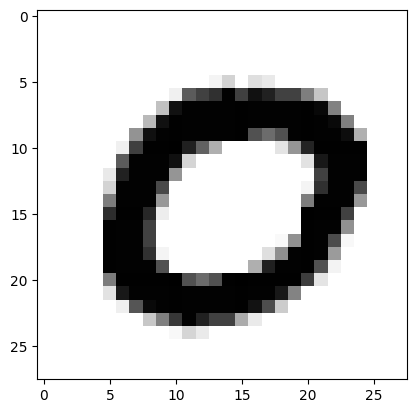

In [29]:
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r');

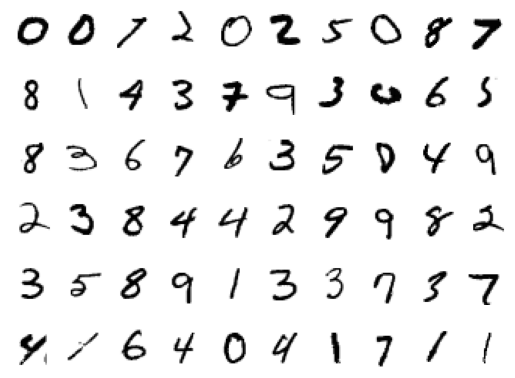

In [30]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## model 
For my model, I used a feedforward neural network with a multi-layer architecture:

Input: The model takes input vectors of size 784, corresponding to flattened 28x28 MNIST images.
Hidden layers: The model has two hidden layers:
The first hidden layer has 128 neurons and uses the ReLU activation function.
The second hidden layer has 64 neurons, also using ReLU as the activation function.
Output: The output layer consists of 10 neurons, representing the 10 classes (digits 0 to 9), with the LogSoftmax activation function, which is suitable for classification tasks with the NLLLoss loss function.

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [8]:
from torchsummary import summary
summary(model, (1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 128]              100,480
├─ReLU: 1-2                              [-1, 1, 128]              --
├─Linear: 1-3                            [-1, 1, 64]               8,256
├─ReLU: 1-4                              [-1, 1, 64]               --
├─Linear: 1-5                            [-1, 1, 10]               650
├─LogSoftmax: 1-6                        [-1, 1, 10]               --
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 128]              100,480
├─ReLU: 1-2                              [-1, 1, 128]              --
├─Linear: 1-3                            [-1, 1, 64]               8,256
├─ReLU: 1-4                              [-1, 1, 64]               --
├─Linear: 1-5                            [-1, 1, 10]               650
├─LogSoftmax: 1-6                        [-1, 1, 10]               --
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42

In [9]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [10]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 2.6298e-03,  2.6298e-03,  2.6298e-03,  ...,  2.6298e-03,
          2.6298e-03,  2.6298e-03],
        [-3.4926e-04, -3.4926e-04, -3.4926e-04,  ..., -3.4926e-04,
         -3.4926e-04, -3.4926e-04],
        [-1.4283e-03, -1.4283e-03, -1.4283e-03,  ..., -1.4283e-03,
         -1.4283e-03, -1.4283e-03],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.1305e-03,  2.1305e-03,  2.1305e-03,  ...,  2.1305e-03,
          2.1305e-03,  2.1305e-03],
        [ 6.6443e-05,  6.6443e-05,  6.6443e-05,  ...,  6.6443e-05,
          6.6443e-05,  6.6443e-05]])


## train
 trains a model  12 epochs, calculating and storing the loss and accuracy for both the training and validation sets. After each epoch, it prints these metrics. The model's performance is tracked and can be visualized using matplotlib after training.








In [11]:
import matplotlib.pyplot as plt

# Initialisation des listes pour stocker les métriques
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 12

for e in range(epochs):
    running_loss = 0
    correct_train = 0
    total_train = 0
    
    # Training loop
    model.train()
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(trainloader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_images, val_labels in valloader:
            val_images = val_images.view(val_images.shape[0], -1)
            val_output = model(val_images)
            val_loss += criterion(val_output, val_labels).item()
            _, val_predicted = torch.max(val_output, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()
    
    val_loss /= len(valloader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {e+1}/{epochs} - "
          f"Training loss: {train_loss:.4f}, "
          f"Training accuracy: {train_accuracy:.4f}, "
          f"Validation loss: {val_loss:.4f}, "
          f"Validation accuracy: {val_accuracy:.4f}")

print("\nTraining Time (in minutes) =", (time() - time0) / 60)


Epoch 1/12 - Training loss: 0.6255, Training accuracy: 0.8177, Validation loss: 0.2909, Validation accuracy: 0.9131
Epoch 2/12 - Training loss: 0.2823, Training accuracy: 0.9163, Validation loss: 0.2345, Validation accuracy: 0.9310
Epoch 3/12 - Training loss: 0.2196, Training accuracy: 0.9352, Validation loss: 0.1913, Validation accuracy: 0.9411
Epoch 4/12 - Training loss: 0.1797, Training accuracy: 0.9476, Validation loss: 0.1602, Validation accuracy: 0.9512
Epoch 5/12 - Training loss: 0.1532, Training accuracy: 0.9555, Validation loss: 0.1401, Validation accuracy: 0.9589
Epoch 6/12 - Training loss: 0.1323, Training accuracy: 0.9607, Validation loss: 0.1207, Validation accuracy: 0.9625
Epoch 7/12 - Training loss: 0.1164, Training accuracy: 0.9657, Validation loss: 0.1219, Validation accuracy: 0.9629
Epoch 8/12 - Training loss: 0.1023, Training accuracy: 0.9702, Validation loss: 0.1107, Validation accuracy: 0.9665
Epoch 9/12 - Training loss: 0.0924, Training accuracy: 0.9723, Validatio

## plot 
** The model was trained on the MNIST dataset for 12 epochs. During training, the loss decreased from 0.6255 to 0.0715, and the accuracy increased from 81.77% to 97.82%. The validation loss changed from 0.2909 to 0.0861, while the validation accuracy improved from 91.31% to 97.39%. This shows a continuous improvement in the model's performance over the epochs. **

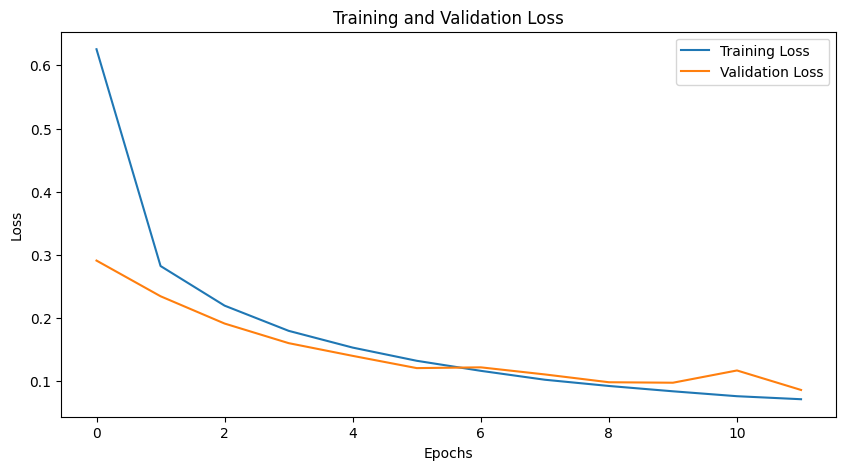

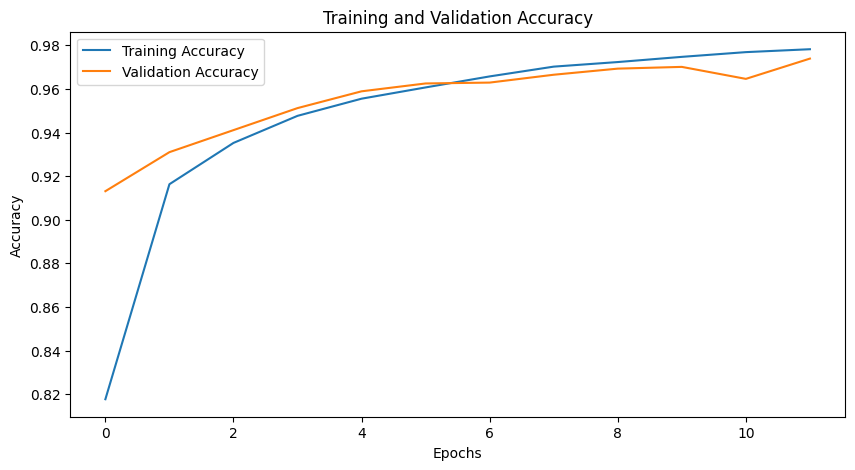

In [12]:
# Tracé des courbes de loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Tracé des courbes d'accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


 now i trying to loads an image from the validation dataset, gets the model’s predicted probabilities for each digit class, and then displays both the image and a bar chart of the predicted probabilities, showing how likely each digit (0-9) is according to the model.

Predicted Digit = 9


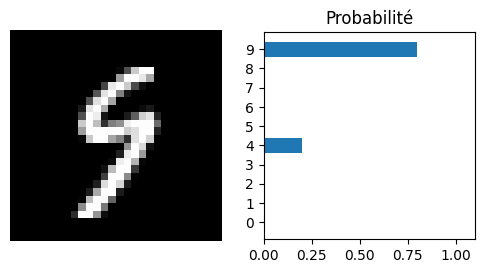

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps):
    ''' Fonction pour afficher l'image d'entrée et le graphique des probabilités prédites '''
    ps = ps.cpu().numpy().squeeze()  # Convertir les tenseurs en numpy et retirer les dimensions inutiles
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.cpu().numpy().squeeze(), cmap='gray')  # Afficher l'image en niveaux de gris
    ax1.axis('off')

    ax2.barh(np.arange(10), ps)  # Afficher les probabilités sous forme de barres horizontales
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Probabilité')
    ax2.set_xlim(0, 1.1)

    plt.show()

# Exemple d'utilisation
images, labels = next(iter(valloader))
img = images[0].view(1, 784)

with torch.no_grad():
    logps = model(img)  # Obtenir les prédictions

ps = torch.exp(logps)  # Obtenir les probabilités en appliquant exp() sur les log-probabilités
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

# Visualiser les prédictions
view_classify(img.view(1, 28, 28), ps)


In [16]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.975


## prediction 
Finally, the code loads an image, applies necessary transformations (resizing, grayscale conversion, normalization), and then passes it through the trained model to predict the digit. The output is the predicted label, which is displayed as the predicted digit.

In [31]:

from PIL import Image
import torchvision.transforms as transforms

# Define transformations to preprocess the image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if not already
    transforms.Resize((28, 28)),                 # Resize to 28x28 to match MNIST data
    transforms.ToTensor(),                       # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))         # Normalize values (same as for training)
])

# Load the image
image_path = "output.png"
image = Image.open(image_path)

# Apply the transformations
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Flatten the image to match the model's expected format
image_tensor = image_tensor.view(-1, 28 * 28)  # Convert to a 784-size vector

# Set the model to evaluation mode
model.eval()

# Make the prediction
with torch.no_grad():
    output = model(image_tensor)
    predicted_label = torch.argmax(output, dim=1).item()

print(f"The image is predicted as the digit: {predicted_label}")


The image is predicted as the digit: 1


## bibliography
#https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627